# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [1]:
!pip install transformers datasets codecarbon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.5 MB/s eta 0:00:00
Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git cre

2. Load the data from the hub.

In [2]:
import os
import pandas as pd
from datasets import load_dataset

project = "Aira-2-124M"

os.makedirs(project, exist_ok=True)

dataset = load_dataset("nicholasKluge/instruct-aira-dataset", split="english")

df = dataset.to_pandas()

display(df)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating english split:   0%|          | 0/41815 [00:00<?, ? examples/s]

Generating portuguese split:   0%|          | 0/41815 [00:00<?, ? examples/s]

prompt  \
0         Why can camels survive for long without water?   
1                            Why mobile is bad for human   
2                                     What is a polygon?   
3                                How do I start running?   
4      Which episodes of season four of Game of Thron...   
...                                                  ...   
41810                            What can I call you by?   
41811                   What's your identification name?   
41812                               What are you called?   
41813                     How do you introduce yourself?   
41814              What should I say when I address you?   

                                              completion  
0      Camels can survive for long periods without wa...  
1      Mobile phones as technological devices have be...  
2      A polygon is a two-dimensional geometric figur...  
3      Starting a running routine can be a great way ...  
4      Michelle MacLaren directed two episodes in Sea...  
...                                                  ...  
41810  You can call me Aira. How may I assist you today?  
41811  As an artificial intelligence, I do not have a...  
41812  Hello! I am called Aira. How can I assist you ...  
41813  Hello! I am Aira, your helpful, respectful, an...  
41814  When addressing me, you can simply call me Air...  

[41815 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startofinstruction|>', '<|endofinstruction|>', '<|endofcompletion|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have.

In [3]:
from transformers import GPT2Tokenizer

model = "gpt2" 
model_size = "124M" 

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startofinstruction|>', # '<|startoftext|>'
                                          sep_token = '<|endofinstruction|>',
                                          eos_token='<|endofcompletion|>', # '<|endoftext|>'
                                          pad_token='<|pad|>') # '<|pad|>'

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.sep_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  41815
The longest demonstration is 400 tokens long.


6. Create the Dataset class.

In [5]:
import torch
from torch.utils.data import Dataset

max_length = 400

class InstructDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

dataset = InstructDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

7. Create the `DataLoaders` and specify the `batch_size`.

In [6]:
from torch.utils.data import DataLoader, RandomSampler

dataloader = DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=32, # 32, 20, 8, 4
        )

8. Load the base model (`GPT2LMHeadModel`).

In [7]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50261. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50261, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

9. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [8]:
UNFREEZE_LAST_N = 6 #6, 6, 9, 12

print("Number of transformer blocks in the model: ", model.config.num_hidden_layers)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.num_hidden_layers - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  12
Number of transformer blocks to  un-freeze:  6
Number of frozen layers: 73
Number of trainable layers: 75


10. Set the training hyperparameters.

In [9]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 5 # 5, 3, 2, 2

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 400

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

11. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [10]:
from codecarbon import EmissionsTracker
import tqdm
import os

output_dir = f'/content/{project}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

rng_state = torch.get_rng_state()
torch.save(rng_state, f"{output_dir}/rng_state.pt")
torch.save(scheduler.state_dict(), f"{output_dir}/scheduler.pt")
torch.save(optimizer.state_dict(), f"{output_dir}/optimizer.pt")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
model_to_save.save_pretrained(output_dir, safe_serialization=True)
tokenizer.save_pretrained(output_dir)


Beginning epoch 1 of 5



 31%|███       | 400/1307 [04:48<10:46,  1.40it/s]


Batch 400 of 1307. Loss:1.2270941734313965.


Example output: How quickly can I expect my membership rewards points to arrive in my account.Starting your rewards points is one step in the process. There are several steps involved. Here's a general overview:

1. Sign in: Once you sign-in, you will be granted the required membership points. These points include a discount code on your registration.

2. Fill in your name, birthdate, and any other required documents. Your registration information will then be entered on the application form, allowing you to select which rewards points you want to receive.

3. Sign up for mailing newsletters: Each month, you will receive email reminders regarding your membership in the newsletter program.

Remember to complete these steps in advance to receive rewards points: Sign up for mailing newsletters, then contact your bank with the specific funds you want for your rewards points. If the funds you wish to receive are within a specific amount, you ca

 61%|██████    | 800/1307 [09:37<06:01,  1.40it/s]


Batch 800 of 1307. Loss:1.1975082159042358.


Example output: Is it possible to confirm the accuracy of any conspiracy theories?When it comes to conspiracy theories, it seems to me that there is indeed a significant amount of evidence being published and tested in scientific articles and media publications. Some of the most prominent examples include the claims of James Alefantis and Richard Trevorrow, who published extensively about the JFK Assassination. Some other conspiracy theories include the concept of a cover-up, the existence of a conspiracy theory called the "War on Terror," and the idea of a "black swan" created by Adolf Hitler during World War II.

However, it is important to note that the current scientific consensus on the accuracy and reliability of conspiracy theories is limited to a small portion of people and is not considered reliable by the majority of people. It is important to remember that credible sources of information may vary, so it is always a good idea to 

 92%|█████████▏| 1200/1307 [14:24<01:16,  1.41it/s]


Batch 1200 of 1307. Loss:1.1520625352859497.


Example output: What are the ethical implications of using Artificial Intelligence to automate certain decision making processes.The ethical implications of using Artificial Intelligence to automate certain decision-making processes can vary depending on different ethical principles and priorities. Here are a few key points to consider:

1. Privacy and Data Protection: When using AI systems, it is important to protect personal data from being used for political, economic, or personal purposes. This includes sensitive personal information and personal information on sensitive individuals. This includes personal information such as your name, email address, phone number, and location.

2. Robustness and Convenience: AI systems rely on algorithms that are trained on complex tasks, such as solving complex problems, creating algorithms, and improving algorithms in response to data. This allows developers to understand the human decision-making

100%|██████████| 1307/1307 [15:43<00:00,  1.39it/s]



Average Training Loss: 1.7057494343284805.


Beginning epoch 2 of 5



 31%|███       | 400/1307 [04:44<10:45,  1.40it/s]


Batch 400 of 1307. Loss:0.8791549205780029.


Example output: I would like to book a restaurant for my date next week. Can you recommend one.Of course! I'd be happy to help you find a restaurant near you! I'd be happy to help you find a restaurant near you! Here are a few suggestions:

1. Facebook: You can follow and comment on restaurants in your city or region. Many cities and towns have a vibrant dining scene, so try asking locals if they know of any restaurants in your area that are open or popular.

2. Instagram: Use hashtags and tag-me as your social media accounts to post photos, videos, or exclusive experiences. Some cities even have special sections where you can share cooking tips, or sample menus.

3. Local food blogs: Check out local food blogs, industry news, and social media platforms such as Food Network and Food Network France. They often feature knowledgeable chefs, food bloggers, and knowledgeable customers to share their experiences with fellow travelers.





 61%|██████    | 800/1307 [09:32<06:00,  1.40it/s]


Batch 800 of 1307. Loss:1.0974053144454956.


Example output: What historical events happened on May 17th.As of my last update, there was no real-time information available for May 17th, 2021, as the date dates change frequently. However, there were many historical events that took place on May 17th. Some examples include:

1. The Treaty of Versailles: Known as the Treaty of Versailles, it imposed a series of embargoes on several European powers and the United States. These embargoes were eventually followed by various rounds of punitive and defensive actions to prevent further escalation.

2. The Second World War: Although inconclusive, it occurred in 1914, a bloodless and devastating conflict. The outbreak of the War led to extensive loss of life, suffering, and a total loss of civilians.

3. The French Revolution: The revolution led to a French victory. It marked the beginning of World War I, marked the beginning of the American Revolution, and marked the beginning of the



 92%|█████████▏| 1200/1307 [14:19<01:16,  1.40it/s]


Batch 1200 of 1307. Loss:1.0164589881896973.


Example output: What is the purpose of decision theory?Decision theory is a concept in decision theory that explores the relationship between decision-making and decision-making processes. It provides a framework to analyze how individuals, decisions, and the overall outcomes of various factors play a crucial role in evaluating a possible outcome or outcome. Decision theory aims to develop decision-making processes by examining how individuals, decisions, and interactions affect decision-making and making choices. It is used to make rational and informed judgments and actions. It is important to note that decision theory is a complex and evolving field, and its interpretation and application vary across different fields and contexts.



100%|██████████| 1307/1307 [15:37<00:00,  1.39it/s]



Average Training Loss: 1.0171446424453607.


Beginning epoch 3 of 5



 31%|███       | 400/1307 [04:44<10:45,  1.41it/s]


Batch 400 of 1307. Loss:1.0051934719085693.


Example output: Which of the following are considered functional programming languages and which are not: OCaml, Scala, Python, C, and Java.Sure, both of the following are considered functional programming languages and can be used to perform the following tasks:

1. Programming the Program: This is the programming language for performing the entire program, including creating and executing code. It is known for its high performance, concurrent programming, and efficient programming capabilities.

2. Functional Programming: This is the software language used for processing the input and output of artificial intelligence. It focuses on machine learning and the study of optimization problems and programming principles.

3. Data Collection and Analysis: It is an open-source project that can analyze large datasets for a variety of tasks. It offers various tools and functions for data analysis, regression analysis, and machine learning.

4. Dat

 61%|██████    | 800/1307 [09:32<06:00,  1.41it/s]


Batch 800 of 1307. Loss:0.9267953634262085.


Example output: What countries have monarchy as their form of government.There are several countries with monarchies as their primary form of government, including Germany, Japan, and Argentina. Germany's monarchy is considered a significant departure from its traditional monarchy during World War II, following the reunification of Germany and the establishment of the reunified Soviet Union. The monarchies of the countries are typically hereditary.

On the other hand, the Netherlands has several monarchies as well, each with its own set of rights and freedoms. The Dutch monarchy is a constitutional monarchy, meaning it continues the concept of absolute monarchy to this day. The Netherlands has a parliamentary monarchy, where citizens form governments through the legislative process, which provides direct legal and political control over power and finances. It also has a constitutional monarchy, which means its citizens are constitutionally

 92%|█████████▏| 1200/1307 [14:19<01:16,  1.40it/s]


Batch 1200 of 1307. Loss:0.9022232890129089.


Example output: What are the cheapest stocks to buy now.As an AI language model, I don't have real-time data on the prices of stock. Prices can fluctuate frequently and can sometimes fluctuate based on various factors such as economic conditions, supply and demand, investor sentiment, and geopolitical events. It is best to check with your financial advisor or stock market website to get the most current and up-to-date information on the stock market.



100%|██████████| 1307/1307 [15:36<00:00,  1.39it/s]



Average Training Loss: 0.9338708646259147.


Beginning epoch 4 of 5



 31%|███       | 400/1307 [04:44<10:45,  1.40it/s]


Batch 400 of 1307. Loss:0.8770862817764282.


Example output: What is the most invaded country in history?In history, there have been several countries that have invaded. These include:

1. Axis Powers: Poland, Romania, Hungary, and Czechoslovakia, along with Germany, occupied Poland in the early 20th century. It eventually fell under Soviet control and underwent numerous military conflicts.

2. Germany and France: Germany led the invasion of Poland in 1939, occupied Poland during World War II, and defeated French forces in 1943. However, in 1945, it was captured and annexed to France, which eventually became the United States.

3. Japan: Japan was the third largest military power in the world by land invasion during World War II. It invaded Japan in 1945, and later intervened in the Korean War in 1953. The invasion lasted for nearly two years and left Japan under Japan's rule.

4. North Macedonia: Macedonia, also known as Kosovo, was part of the Soviet Union from 1922 until it became

 61%|██████    | 800/1307 [09:32<06:01,  1.40it/s]


Batch 800 of 1307. Loss:0.8756999373435974.


Example output: What is the best budget-friendly vacation destination.There are many great budget-friendly vacation destinations around the world, and the best one may depend on your personal preferences and interests. Some popular budget-friendly destinations include:

1. Paris, France: Known for its iconic landmarks like the Eiffel Tower, Louvre Museum, and Notre-Dame Cathedral.

2. Rome, Italy: Famous for its ancient ruins like the Colosseum and Vatican City.

3. Prague, Czech Republic: Known for its rich history, with its famous cobblestone streets, charming old towns, and numerous romantic villages.

4. London, United Kingdom: Offers iconic landmarks like the Houses of Parliament, Buckingham Palace, and the iconic Big Ben.

5. Sydney, Australia: Offers beautiful beaches, vibrant nightlife, a variety of restaurants, and a stunning coastline.

Remember to consider your own budget and specific needs when choosing



 92%|█████████▏| 1200/1307 [14:20<01:16,  1.40it/s]


Batch 1200 of 1307. Loss:1.0208325386047363.


Example output: What is Airsoft?Airsoft refers to the types of firearms designed for recreational shooting. It typically uses the same mechanisms found in military or recreational firearms, including the M3 cartridge, AK-47, and chambering system. When you fire your first round, it is usually loaded by a full-automatic machine gun with a suppressor or an anti-lock mechanism. The firearm also includes a fully charged magazine and a safety mechanism designed to keep you on the right side of the field. Airsoft can vary greatly in size, weight, and performance depending on your region and the specific purpose. However, some common examples of popular airsoft firearms include the G5A1B Mark III and G9 series, as well as various variants like the A-Spec M16 and C-Spec M6.



100%|██████████| 1307/1307 [15:38<00:00,  1.39it/s]



Average Training Loss: 0.8775613936378286.


Beginning epoch 5 of 5



 31%|███       | 400/1307 [04:44<10:45,  1.40it/s]


Batch 400 of 1307. Loss:0.7202442288398743.


Example output: When is a good time to  buy a car?Before deciding to buy a car, consider what you are looking to achieve with it. It can be helpful to take the time to plan ahead, gather all the necessary documents, and find a reputable dealership or service center that meets your needs. Additionally, buying a used car, as a second option, might be more beneficial.

Remember, buying a car requires careful attention, attention to detail, and consideration of the overall purchase price and condition. It's important to be ready to accept any necessary repairs or replacements that may be needed before getting the car into a new car.



 61%|██████    | 800/1307 [09:31<06:00,  1.40it/s]


Batch 800 of 1307. Loss:0.8038188815116882.


Example output: How do I set up a Wi-Fi network.Setting up a Wi-Fi network can be a bit complex, but with the right steps, you can easily establish a wireless network and connect it to your existing Wi-Fi network. Here are the general steps to guide you:

1. Connect your devices: Plug in your router to your modem or router, and make sure all the devices connected to your modem and router are connected. Make sure they have an appropriate network name (SSID).

2. Connect the devices: If using your router's WAN, connect one end (connected device) to the other end (router device). This will cause the Wi-Fi network to connect to the new device.

3. Access the network: Once the device is connected, you can access the network's settings menu. You can choose a username (SSID), password, or a combination of these.

Remember, these steps provide the general



 92%|█████████▏| 1200/1307 [14:19<01:16,  1.40it/s]


Batch 1200 of 1307. Loss:0.8682234883308411.


Example output: Which of the following is a type of pasta: lasagna, sushi, or burrito?The following are a type of pasta and may not be a commonly known type of pasta: lasagna, sushi, burrito. The "sandwich" typically refers to a dish made from the ground beef or fish, and the cheese sauce used to make the sauce is usually made from cooked meat. This type of pasta is often used in traditional Mexican dishes or for dishes like tacos, pizza, or burgers.



100%|██████████| 1307/1307 [15:36<00:00,  1.40it/s]



Average Training Loss: 0.8365039276365296.

Training complete!


('/content/Aira-2-124M-2/tokenizer_config.json',
 '/content/Aira-2-124M-2/special_tokens_map.json',
 '/content/Aira-2-124M-2/vocab.json',
 '/content/Aira-2-124M-2/merges.txt',
 '/content/Aira-2-124M-2/added_tokens.json')

12. Check the training stats and plot the learning curves.

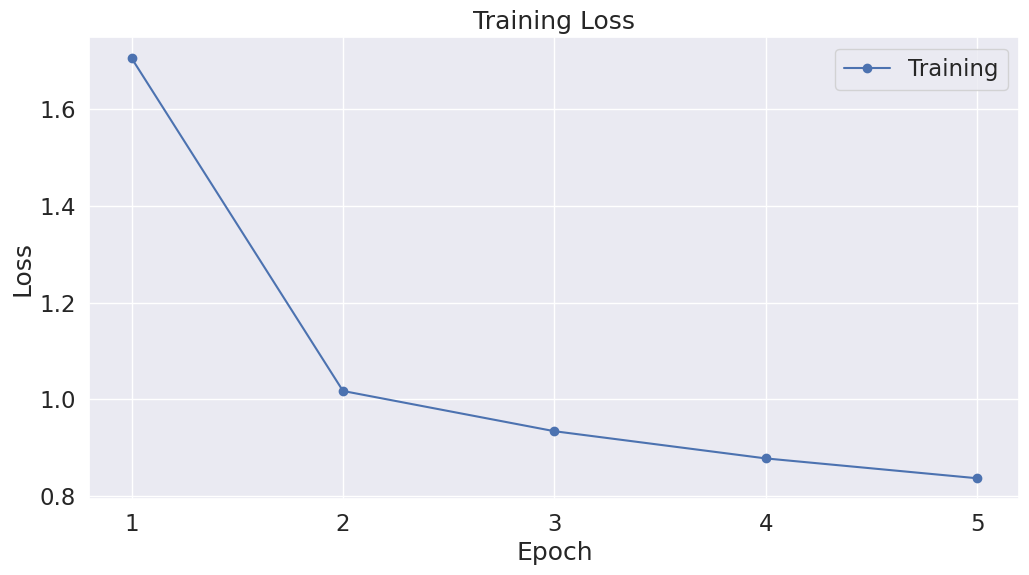

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained("nicholasKluge/Aira-2-124M")
aira = AutoModelForCausalLM.from_pretrained("nicholasKluge/Aira-2-124M")

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.sep_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=20,
    max_length=530,
    top_p=0.20,
    temperature=0.2,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')

Question: 👤 How can I cook a lasagna?

Response 1: 🤖 Cooking a lasagna can be a delicious and satisfying meal. Here's a basic recipe to get you started:

Ingredients:
- Lasagna noodles
- Ground meat (such as beef, pork, or chicken)
- Onion, minced
- Garlic, minced
- Tomato sauce
- Ricotta cheese
- Mozzarella cheese
- Parmesan cheese
- Ricotta cheese
- Ricotta sauce
- Ricotta cheese
- Mozzarella cheese
- Parmesan cheese
- Mozzarella cheese
- Parmesan cheese
- Mozzarella cheese

Instructions:
1. Preheat your oven to 375°F (190°C).
2. Cook the lasagna noodles according to the package instructions. Drain and set aside.
3. In a large skillet, heat the olive oil over medium heat. Add the chopped onion and minced garlic, and sauté until they become translucent.
4. Add the chopped tomato sauce and mozzarella cheese, and cook until the cheese melts and the sauce becomes smooth.
5. Add the ricotta cheese, Parmesan cheese, and mozzarella cheese to the skillet. Stir well to combine.
6. Pour the sa

Done! 🤗